In [3]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.special import softmax
from sklearn.metrics import roc_curve, auc, f1_score
import numpy as np
import matplotlib.pyplot as plt
%matplotlib
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from simpletransformers.classification import MultiLabelClassificationModel
import random
import itertools
from ast import literal_eval
random.seed(1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Using matplotlib backend: agg


### Data Processing

- Convert __top_section__ and __CONSORT_Item__ to one hot encoding
- Convert data into train and test such that test contains atleast single presence of all labels

In [4]:
data_path = "/efs/CONSORT/MLDataset/"
exclude_labels = ["1a", "1b", "2a"]
use_top_section = False
def explode_rows(id_, df):
    df[id_] = df[id_].apply(literal_eval)
    t = df[id_].apply(pd.Series).reset_index().melt(id_vars='index').dropna()[['index', 'value']].set_index('index')
    new_df = pd.merge(t,df.loc[:, df.columns != id_], left_index=True, right_index=True).rename(columns={"value":id_})
    return new_df
    
def preprocess_data(df, text_col="sentence_text", label_col="CONSORT_Item"):
    def one_hot_encoding(df, label_col):
        return df[label_col].str.get_dummies().add_prefix(label_col + "_")        
    one_hot_df = one_hot_encoding(df, label_col)
    num_labels = set(one_hot_df.columns.values)
    one_hot_df["labels"] = list(zip(*[one_hot_df[col] for col in one_hot_df]))
    df = pd.concat([df["PMCID"], df["sentence_id"], df["top_section"], df[label_col], df[text_col], one_hot_df], axis=1)
    df = df.rename(columns={text_col:'text'})
    df["text"] = df["text"].str.lower()
    df["labels"] = df["labels"].apply(lambda x: list(x))
    df = df.groupby(["PMCID", "sentence_id", "text", "top_section"]).agg(
        {"labels" : lambda x: [sum(y) for y in zip(*x)],
         label_col : lambda x: list(x)
        }
    ).reset_index()
    df["n_labels"] = df["labels"].apply(lambda x: sum(x))
    # For top_section
    one_hot_df = one_hot_encoding(df, "top_section")
    df["top_section"] = list(zip(*[one_hot_df[col] for col in one_hot_df]))
    df["top_section"] = df["top_section"].apply(lambda x: list(x))
    return df, len(num_labels)

# Use this for all labels
# all_labels_data = pd.read_csv(os.path.join(data_path, "all_data_manual_Sahil.csv"), engine='python')
# all_labels_data = explode_rows("CONSORT_Item", all_labels_data)
# if len(exclude_labels) > 0:
#     all_labels_data = all_labels_data[~all_labels_data["CONSORT_Item"].isin(exclude_labels)]
# processed_data, n_labels = preprocess_data(all_labels_data)

In [5]:
# Use Linh's dataset
embedding_column = "section"
train_df_linh = pd.read_csv("/efs/CONSORT/MLDataset/manual_train_data_wMetaMap_FINAL_18labels.csv")
# train_df_linh["labels"] = train_df_linh.iloc[:, 6:23].values.tolist()
train_df_linh["CONSORT_Item"] = train_df_linh["CONSORT_Item"].apply(lambda x: literal_eval(x))
train_df_linh["labels"] = train_df_linh["labels"].apply(lambda x: literal_eval(x))
train_df_linh["text"] = train_df_linh[["text", "section"]].apply(lambda x: x["section"] + " " + x["text"], axis=1)
# # train_df_linh = train_df_linh.rename(columns={embedding_column:'top_section'})
# # train_df_linh["top_section"] = train_df_linh["top_section"].apply(lambda x: literal_eval(x))
test_df_linh = pd.read_csv("/efs/CONSORT/MLDataset/manual_test_data_wMetaMap_FINAL_18labels.csv")
# test_df_linh["labels"] = test_df_linh.iloc[:, 6:23].values.tolist()
test_df_linh["CONSORT_Item"] = test_df_linh["CONSORT_Item"].apply(lambda x: literal_eval(x))
test_df_linh["labels"] = test_df_linh["labels"].apply(lambda x: literal_eval(x))
test_df_linh["text"] = test_df_linh[["text", "section"]].apply(lambda x: x["section"] + " " + x["text"], axis=1)
# # test_df_linh = test_df_linh.rename(columns={embedding_column:'top_section'})
# # test_df_linh["top_section"] = test_df_linh["top_section"].apply(lambda x: literal_eval(x))

labels_train = []
for l in list(itertools.chain(train_df_linh["CONSORT_Item"])):
    labels_train.extend([k for k in l])
print(f"train labels {set(labels_train)}")
labels_test = []
for l in list(itertools.chain(test_df_linh["CONSORT_Item"])):
    labels_test.extend(l)
print(f"test labels {set(labels_test)}")
assert len(set(labels_test)) == len(set(labels_train))
print(f"Number of labels = {len(set(labels_train))}")
consort_items = sorted(set(labels_train))
id2index = {}
for i, item in enumerate(consort_items):
    id2index[i] = item
n_labels = len(id2index)
print("Label to Index Dictionary" , id2index)

train labels {'0', '11a', '9', '3b', '7b', '8a', '8b', '7a', '5', '3a', '4b', '4a', '12b', '10', '6a', '12a', '6b', '11b'}
test labels {'0', '11a', '9', '3b', '7b', '8a', '8b', '7a', '5', '3a', '12b', '4b', '4a', '10', '6a', '12a', '6b', '11b'}
Number of labels = 18
Label to Index Dictionary {0: '0', 1: '10', 2: '11a', 3: '11b', 4: '12a', 5: '12b', 6: '3a', 7: '3b', 8: '4a', 9: '4b', 10: '5', 11: '6a', 12: '6b', 13: '7a', 14: '7b', 15: '8a', 16: '8b', 17: '9'}


In [110]:
# train_data = pd.read_csv(os.path.join(data_path, "train_data.csv"), engine='python')
# validation_data = pd.read_csv(os.path.join(data_path, "valid_data.csv"), engine='python')
# test_data = pd.read_csv(os.path.join(data_path, "test_data.csv"), engine='python')
# complete_data = pd.concat([train_data, validation_data, test_data], axis=0)
# unique_labels = set(complete_data["CONSORT_Item"].unique())

In [102]:
# train_data_preprocess, num_labels = preprocess_data(train_data)
# validation_data_preprocess, num_labels = preprocess_data(validation_data)
# test_data_preprocess, num_labels = preprocess_data(test_data)

In [12]:
# print("Unique IDs validation", validation_data_preprocess["PMCID"].unique().shape)
# print("Unique IDS test", test_data_preprocess["PMCID"].unique().shape)
# print("Size of validation data", validation_data_preprocess.shape)
# print("Size of test data", test_data_preprocess.shape)

In [103]:
# complete_ids = list(validation_data_preprocess["PMCID"].unique()) + list(test_data_preprocess["PMCID"].unique())
# complete_ids = list(processed_data["PMCID"].unique())
# split = 0.8
# val_idx = int(len(complete_ids) * split)
# val_ids = complete_ids[0:val_idx]
# tst_ids = complete_ids[val_idx:]
# special_ids = ["PMC3420230", "PMC3944682"]
# for i_d in special_ids:
#     val_ids.remove(i_d)
#     tst_ids.append(i_d)
# temp = processed_data
# val_df = temp[temp["PMCID"].isin(val_ids)]
# tst_df = temp[temp["PMCID"].isin(tst_ids)]

In [231]:
# temp = pd.concat([validation_data_preprocess, test_data_preprocess], ignore_index=True)
# val_df.to_csv("/efs/sahilw2/data/split_train.csv", index=False)
# tst_df.to_csv("/efs/sahilw2/data/split_test.csv", index=False)

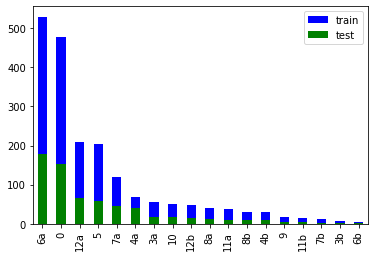

In [6]:
%matplotlib inline
ax1 = plt.subplot(1,1,1)
train_distribution_linh = train_df_linh.explode("CONSORT_Item")["CONSORT_Item"].value_counts()
test_distribution_linh = test_df_linh.explode("CONSORT_Item")["CONSORT_Item"].value_counts()
train_distribution_linh.plot(kind="bar", ax = ax1, color="b")
test_distribution_linh.plot(kind="bar", ax=ax1, color="g")
plt.legend(["train", "test"])
plt.show();

In [122]:
# print("Labels distribution for training and testing...")
# print(pd.DataFrame({"train" : all_labels_data[all_labels_data["PMCID"].isin(val_ids)]["CONSORT_Item"].value_counts(), "test" : all_labels_data[all_labels_data["PMCID"].isin(tst_ids)]["CONSORT_Item"].value_counts()}))
# print(len(all_labels_data["top_section"].unique()), all_labels_data["top_section"].unique())

In [138]:
# print("validation data size", val_df.shape)
# print("test data size", tst_df.shape)
# print("Train PMCID - ", val_df["PMCID"].unique())
# print("Test PMCID - ", tst_df["PMCID"].unique())

In [139]:
# for rare labels only
# validation_org = validation_data[validation_data["PMCID"].isin(val_ids)]
# labels_proportion = validation_org["CONSORT_Item"].value_counts() / sum(validation_org["CONSORT_Item"].value_counts())
# labels_proportion = pd.DataFrame(labels_proportion)
# rare_labels = labels_proportion[labels_proportion["CONSORT_Item"] < 0.01]
# train_ids_rare = train_data[train_data["CONSORT_Item"].isin(rare_labels.index.tolist())]
# train_data_rare = train_data_preprocess[train_data_preprocess["PMCID"].isin(train_ids_rare["PMCID"].tolist())]

In [140]:
# train_data_rare.to_csv("/efs/sahilw2/data/rare_data.csv")

In [9]:
# train_validation_data = pd.concat([train_data_rare, val_df], ignore_index=True)
# # validation_data_preprocess.head()
# train_validation_data["n_labels"].value_counts(dropna=False)

In [7]:
if not use_top_section:
    train_df_linh["top_section"] = 1
    test_df_linh["top_section"] = 1
    n_top_sections = 0
else:
    assert "top_section" in train_df_linh.columns
    n_top_sections = len(train_df_linh["top_section"].iloc[0])
config = {'reprocess_input_data': True,
          'fp16':False,
          "evaluate_during_training": False,
          "output_dir": "/efs/sahilw2/model/manual_linh_top_section_concat_2", 
          'train_batch_size': 4,
          'gradient_accumulation_steps':16,
          'learning_rate': 3e-5, 
          'num_train_epochs': 30,
          'n_top_sections': n_top_sections, 
          "overwrite_output_dir": True,
          "do_lower_case": True,
          'max_seq_length': 512}
model = MultiLabelClassificationModel('bert', '/efs/sahilw2/model/manual_linh_top_section_concat_2/', num_labels=n_labels, args=config)
# model.train_model(train_df_linh)

In [8]:
# model = MultiLabelClassificationModel('bert', 'outputs/checkpoint-95-epoch-5/', num_labels=num_labels, args=config)
test_predictions = model.predict(test_df_linh["text"].tolist(), test_df_linh["top_section"].tolist())
for i in range(len(test_predictions[0])):
    if sum(test_predictions[0][i]) == 0:
        test_predictions[0][i][0] = 1
print("Accuracy", accuracy_score(test_predictions[0], test_df_linh["labels"].tolist()))


Accuracy 0.7035830618892508


In [12]:
# predicted_labels = []
# for l in test_predictions[0]:
#     predicted_labels.append([id2index[i] for i in range(len(l)) if l[i]])
# tst_df["predicted_labels"] = predicted_labels

# tst_df.to_csv("full_data/results.csv", index=False)

In [11]:
# test_predictions_items = []
# for t in test_predictions[0]:
#     l = []
#     for i, j in enumerate(t):
#         if j:
#             l.append(id2index[i])
#     test_predictions_items.append(l)
    
# validation_data_preprocess["predictions"] = test_predictions_items

In [13]:
# halil's logic
new_test_predictions=[]
gold_labels=[]
for i in range(len(test_predictions[0])):
    x = test_predictions[0][i]
    new_test_predictions.append(x[1:])

for i in range(len(test_df_linh["labels"])):
    y = test_df_linh["labels"][i]
    gold_labels.append(y[1:])

print("Accuracy", accuracy_score(new_test_predictions, gold_labels))


predicted_labels = []

for l in new_test_predictions:
    predicted_labels.append([id2index[i] for i in range(len(l)) if l[i]])
print("F1 Score" , f1_score(gold_labels, new_test_predictions, average="micro"))
print("ROC ", roc_auc_score(gold_labels, new_test_predictions))
id2index1 = {}
for i, item in enumerate(consort_items):
    if item == '0':
        continue
    id2index1[i] = item

print(classification_report(gold_labels, new_test_predictions, \
                            target_names=list(id2index1.values())))


Accuracy 0.7035830618892508
F1 Score 0.7565217391304347
ROC  0.6877378706440039
              precision    recall  f1-score   support

          10       0.00      0.00      0.00        17
         11a       0.50      0.40      0.44        10
         11b       0.00      0.00      0.00         4
         12a       0.75      0.76      0.75        66
         12b       0.17      0.19      0.18        16
          3a       0.89      0.47      0.62        17
          3b       0.00      0.00      0.00         3
          4a       0.89      0.82      0.86        40
          4b       1.00      0.44      0.62         9
           5       0.85      0.80      0.82        59
          6a       0.85      0.86      0.86       179
          6b       0.00      0.00      0.00         1
          7a       1.00      0.76      0.86        45
          7b       0.00      0.00      0.00         3
          8a       1.00      0.33      0.50        12
          8b       1.00      0.70      0.82        10
 

/home/sahilw2/anaconda3/envs/simpletransformers/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sahilw2/anaconda3/envs/simpletransformers/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sahilw2/anaconda3/envs/simpletransformers/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

In [22]:
# results based on including 0 label
print("F1 Score" , f1_score(test_df_linh["labels"].tolist(), test_predictions[0], average="micro"))
print("ROC ", roc_auc_score(test_df_linh["labels"].tolist(), test_predictions[0]))
print(classification_report(test_df_linh["labels"].tolist(), test_predictions[0], \
                            target_names=list(id2index.values())))

F1 Score 0.7192429022082019
ROC  0.691753825755817
              precision    recall  f1-score   support

           0       0.55      0.71      0.62       152
          10       0.00      0.00      0.00        17
         11a       0.50      0.40      0.44        10
         11b       0.00      0.00      0.00         4
         12a       0.75      0.76      0.75        66
         12b       0.17      0.19      0.18        16
          3a       0.89      0.47      0.62        17
          3b       0.00      0.00      0.00         3
          4a       0.89      0.82      0.86        40
          4b       1.00      0.44      0.62         9
           5       0.85      0.80      0.82        59
          6a       0.85      0.86      0.86       179
          6b       0.00      0.00      0.00         1
          7a       1.00      0.76      0.86        45
          7b       0.00      0.00      0.00         3
          8a       1.00      0.33      0.50        12
          8b       1.00      0

/home/sahilw2/anaconda3/envs/simpletransformers/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
